# Projet d'apprentissage profond pour les images - Quang-Duy Nguyen, Morgan Ramadani
## 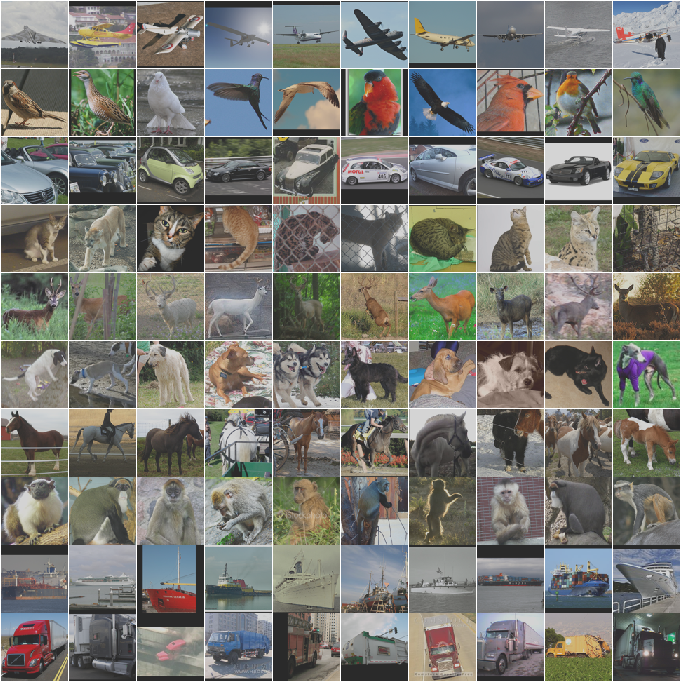

## Installation & Imports

In [ ]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" or :
    # download data if needed
    # download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    # save_images(images, labels)

In [151]:
images = read_all_images(DATA_PATH)

labels = read_labels(LABEL_PATH)

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

## Data Exploration

In [34]:
# Vérifier qu'il y a pas de déséquilibre de classes
print(np.array(np.unique(labels, return_counts=True)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


In [38]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [26]:
# Division des données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Division de l'ensemble d'entraînement en ensembles d'entraînement et de validation (80% pour l'entraînement, 20% pour la validation)
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Convertir les étiquettes en codage à chaud (one-hot encoding)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels-1, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Vérification des dimensions des ensembles
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", valid_images.shape, valid_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)


Training set: (3200, 96, 96, 3) (3200, 10)
Validation set: (800, 96, 96, 3) (800, 10)
Test set: (1000, 96, 96, 3) (1000, 10)


## Baseline

### Baseline w/o Attention

In [ ]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
                    train_images, train_labels,
                    epochs=3,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/3
25/25 [==============================] - 2s 30ms/step - loss: 16.3370 - accuracy: 0.1144 - val_loss: 2.2642 - val_accuracy: 0.1863
Epoch 2/3
25/25 [==============================] - 1s 23ms/step - loss: 2.1920 - accuracy: 0.1819 - val_loss: 2.0943 - val_accuracy: 0.2013
Epoch 3/3
25/25 [==============================] - 1s 22ms/step - loss: 2.1003 - accuracy: 0.2153 - val_loss: 2.0688 - val_accuracy: 0.2175


In [32]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 2.1000 - accuracy: 0.2160
Test Loss: 2.0999855995178223
Test Accuracy: 0.2160000056028366


### Baseline w Attention

In [42]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.query = layers.Dense(self.channels)
        self.key = layers.Dense(self.channels)
        self.value = layers.Dense(self.channels)
        self.gamma = self.add_weight("gamma", shape=[1], initializer="zeros", trainable=True)

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_weights = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        attention_output = tf.matmul(attention_weights, value)
        scaled_attention = self.gamma * attention_output + x
        return scaled_attention

In [44]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
x = SelfAttention()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model2 = models.Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 22, 22, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 32)        4640

In [45]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model2.fit(
                    train_images, train_labels,
                    epochs=3,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/3
25/25 [==============================] - 3s 32ms/step - loss: 20.2109 - accuracy: 0.1141 - val_loss: 2.4977 - val_accuracy: 0.1350
Epoch 2/3
25/25 [==============================] - 1s 23ms/step - loss: 2.2745 - accuracy: 0.1581 - val_loss: 2.2468 - val_accuracy: 0.1800
Epoch 3/3
25/25 [==============================] - 1s 23ms/step - loss: 2.1383 - accuracy: 0.2109 - val_loss: 2.1898 - val_accuracy: 0.2288


In [46]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 2.1000 - accuracy: 0.2160
Test Loss: 2.0999855995178223
Test Accuracy: 0.2160000056028366


## Data Augmentation

### Horizontal Flip

In [98]:
images.shape

(5000, 96, 96, 3)

In [132]:
flipped_img = np.empty_like(images)

for i in range(images.shape[0]):
    flipped_img[i] = np.fliplr(images[i])

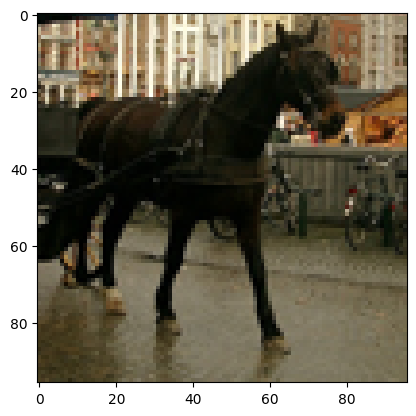

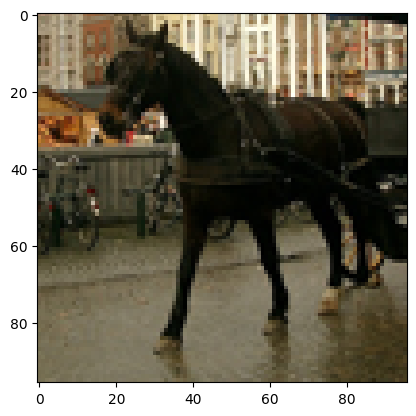

In [143]:
i = 93
plot_image(images[i])
plot_image(flipped_img[i].astype(np.uint8))

In [152]:
images = np.append(images,flipped_img,axis=0)
labels = np.append(labels,labels)

In [153]:
print(images.shape)
print(labels.shape)

(10000, 96, 96, 3)
(10000,)


In [ ]:
# Charger une nouvelle image à prédire
image_path = 'chemin/vers/la/nouvelle/image.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(96, 96))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0  # Normalisation

# Prédiction de l'image
prediction = model.predict(tf.expand_dims(image, axis=0))
predicted_class = tf.argmax(prediction, axis=1)


In [ ]:
pip install tensorflow tensorflow_hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np